https://docs.google.com/spreadsheets/d/1AV-A1uhQqvF6h0_a-fupFQIHv6W7-vNm88AYh_WzeB0/edit#gid=1326833441

You will find Q2 regression data from the link above. 

The data contains 300 rows and 3 columns (from the left, A, B, and C). Please build a good regression model which explains column C by a function of  A and B. 

Note: Please do not use any ML libraries or packages. You can simply attach plot of data points and your regression model that fits the data points and of course, code point (preferably Github).

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [329]:
df = pd.read_csv('regression.csv',header=None,sep=';')
df.rename(columns={ df.columns[0]: 'A' ,df.columns[1]: 'B',df.columns[2]: 'C'}, inplace = True)

df

,A,B,C
0,0.490,-0.180,11.50
1,-1.410,-1.230,11.80
2,0.943,4.510,-3.24
3,3.570,5.070,-23.90
4,-1.700,6.910,-22.10
...,...,...,...
295,6.920,-0.421,33.20
296,11.700,-1.290,108.00
297,9.920,3.690,-126.00
298,11.400,6.290,-315.00


## EDA and Cleaning


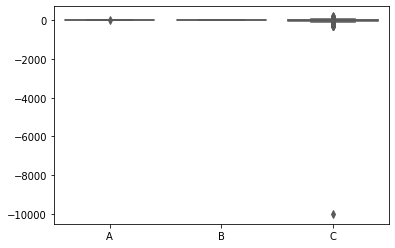

In [330]:
ax = sns.boxplot(data=df, palette="Set2")

First thing we notice is that there's a huge outlier in feature 'C'. If we keep this outlier, it will make our regression model worse since linear regression is sensitive to outliers

In [331]:
#calculate z-score

z = np.abs((df - df.mean())/df.std(ddof=0))


threshold = 3
print(np.where(z > threshold))

(array([200, 209]), array([2, 0]))


One way of dealing with outliers is calculating the z-score. In our dataset, I defined a threshold of 3 standard deviations and set to print all the points that exceed this value. As we can see above, there are 2 points that show as outlier. We will filter these out of our distribution.

In [332]:
df_clean = df[(z < 3).all(axis=1)]

df_clean

,A,B,C
0,0.490,-0.180,11.50
1,-1.410,-1.230,11.80
2,0.943,4.510,-3.24
3,3.570,5.070,-23.90
4,-1.700,6.910,-22.10
...,...,...,...
295,6.920,-0.421,33.20
296,11.700,-1.290,108.00
297,9.920,3.690,-126.00
298,11.400,6.290,-315.00


Now let's plot our features and check it again

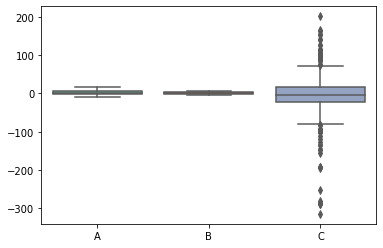

In [333]:
ax = sns.boxplot(data=df_clean, palette="Set2");

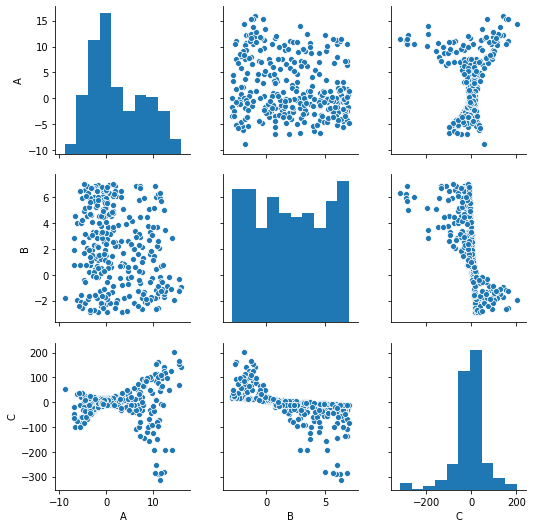

In [334]:
g = sns.pairplot(df_clean);

```sns.pairplot```allows us to draw some quick inferences about our data. We see that feature C follows almost a gaussian distribution. Let's take a look at these distributions closely. 

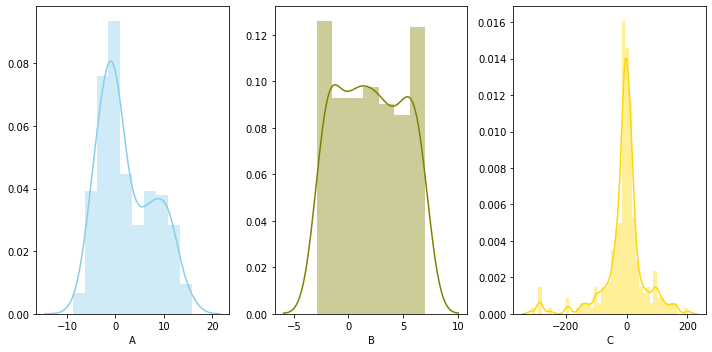

In [335]:
f, axes = plt.subplots(1, 3, figsize=(10, 5))
sns.distplot(df_clean.iloc[:,0], color="skyblue", ax=axes[0])
sns.distplot(df_clean.iloc[:,1], color="olive", ax=axes[1])
sns.distplot(df_clean.iloc[:,2], color="gold", ax=axes[2])

plt.tight_layout()

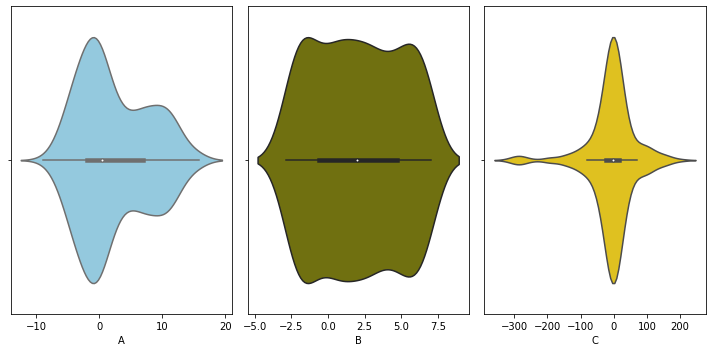

In [336]:
f, axes = plt.subplots(1, 3, figsize=(10, 5))
sns.violinplot(df_clean.iloc[:,0], color="skyblue", ax=axes[0])
sns.violinplot(df_clean.iloc[:,1], color="olive", ax=axes[1])
sns.violinplot(df_clean.iloc[:,2], color="gold", ax=axes[2])

plt.tight_layout()

We see that indeed C follows an almost gaussian while A is bimodal. However, it'd be good to know what kind of relationship we have between these variables. Therefore, we will check the correlation between the 3 features in the next analysis. 

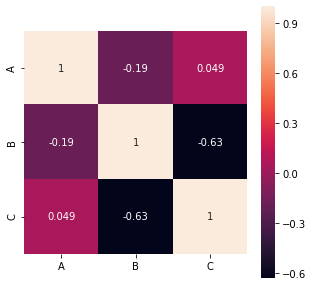

In [337]:
# from seaborn manual
# Compute the correlation matrix
corr = df_clean.corr()

plt.figure(figsize=(5,5))
ax = sns.heatmap(corr,annot=True,square=True)
#workaround for boxes being cut
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show();

First thing we notice is that B and C are negatively correlated. The other variables show weak correlation.

## Modelling

Now that we undertand our dataset, we will try to build a multiple linear regression model. Let's start by scaling our dataframe, this will make out model converge much quicker.

In [338]:
df_scaled = (df_clean - df_clean.mean())/df_clean.std(ddof=0)

df_scaled

,A,B,C
0,-0.311367,-0.737698,0.270966
1,-0.651456,-1.088457,0.275254
2,-0.230283,0.829027,0.060250
3,0.239934,1.016099,-0.235095
4,-0.703364,1.630762,-0.209363
...,...,...,...
295,0.839565,-0.818206,0.581178
296,1.695156,-1.108501,1.650482
297,1.376547,0.555101,-1.694666
298,1.641458,1.423647,-4.396516


Let's divide into target and features

In [339]:
# set the x and y variable; define no. of training samples
X = df_scaled.iloc[:,0:2] #features
y = df_scaled.iloc[:,2] # target
arr_len = len(y) # no. of training samples


Define the parameters of our regression model

In [340]:
array_ones = np.ones((arr_len,1))
X = np.hstack((array_ones, X))
alpha = 0.01 #we set a learning ratio alpha 
num_iters = 10000
theta = np.zeros((1,3)) 
y = y[:,np.newaxis] #Increases y dimension 


Create a cost function. The main goal is to minimize this function

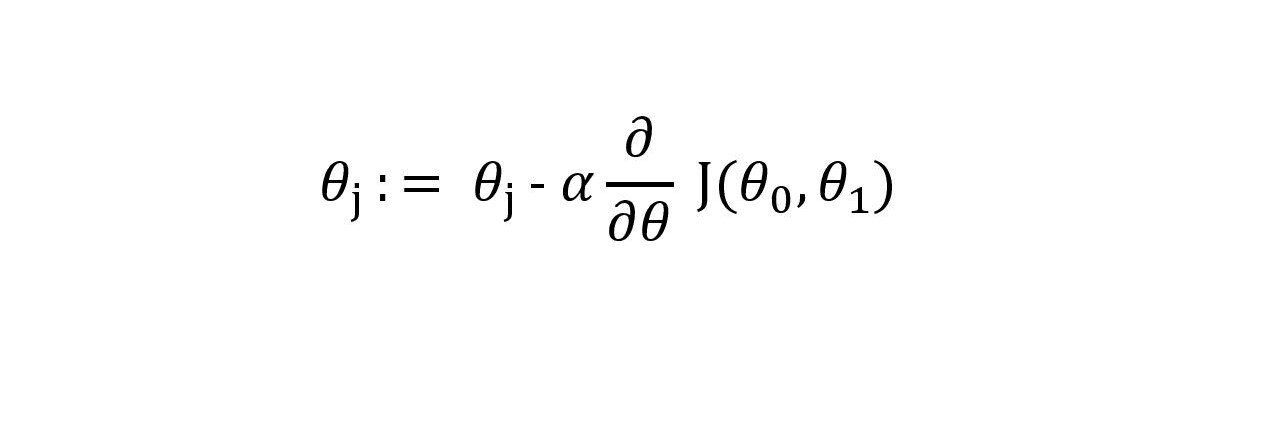

In [341]:
# The X @ theta.T is a is a matrix operation. More efficient than for loops.
def cost_function(X,y,theta):
    power = np.power(((X @ theta.T)-y),2)
    return np.sum(power)/(2 * len(X))


Create a gradient descent function

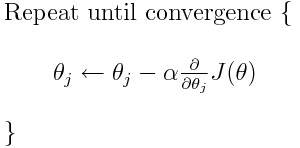

In [342]:
def gradient_descent(X,y,theta,n_iters,alpha):
    
    cost = np.zeros(n_iters)
    for i in range(n_iters):
        theta = theta - (alpha/len(X)) * np.sum(X * (X @ theta.T - y), axis=0)
        cost[i] = cost_function(X, y,theta)
    
    return theta,cost

theta,cost = gradient_descent(X,y,theta,num_iters,alpha)

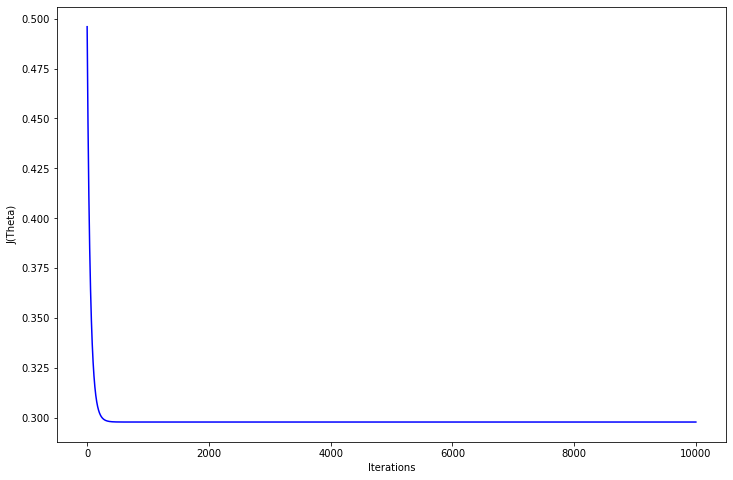

In [343]:
fig,ax = plt.subplots(figsize=(12,8))

ax.set_ylabel('J(Theta)')
ax.set_xlabel('Iterations')
ax=ax.plot(np.arange(num_iters),cost,'b')

We didn't even need to run 1000 iterations. Our model converged earlier

## Model Evaluation

In [344]:
#get an estimate for y_pred
def ypredict(X, theta):
        return np.dot(X,theta.T )

y_pred = ypredict(X, theta) 

Calculate Mse, RMSE and R2

In [345]:
# mean squared error
mse = np.sum((y_pred - y)**2)

# root mean squared error
# divide the number of training examples
rmse = np.sqrt(mse/arr_len)

mean_y = np.mean(y)
sst = sum((y - mean_y) ** 2)
sse = sum((y - y_pred) ** 2)
r2 = 1 - (sse / sst)

In [346]:
s = 'The MSE, RMSE and R2 scores are: ' + repr(mse) + ', ' + repr(rmse) + ' and '+ repr(r2)
print(s)

The MSE, RMSE and R2 scores are: 177.51509949444034, 0.7718084304651305 and array([0.40431175])


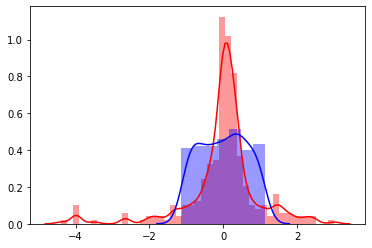

In [347]:
# Draw the scatter plot


ax1 = sns.distplot(y, hist=True, color="r", label="Actual Value")
sns.distplot(y_pred, hist=True, color="b", label="Fitted Values" , ax=ax1)

The model gets the general pattern, but it doesn't fit perfectly. Perhaps, some more advanced regression techniques such as random forest regression could have a better result.

## The wrap up 

As I am using only standard libraries, creating more complex models is difficult. However, with more time it'd be possible to apply a different models (e.g. Random forest regressor) and maybe some cross-validation. In the case of the linear regression, it'd be interesting to apply a regularization term to avoid overfitting. The command of the assignment states that we have to use A and B to predict C, but maybe excluding A since it has almost no correlation (as stated in the EDA) could improve the model. However, this is beyond the scope of this notebook.